In [4]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "04_problem_types/10d_counting.ipynb"
_nb_title = "Counting objects based on density"
_nb_message = """
This notebook shows you how to count the number of objects in an image based on the density.
This way, it is not necessary to correctly identify individual objects.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Counting+objects+based+on+density&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_problem_types%2F10d_counting.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10d_counting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/10d_counting.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_problem_types/10d_counting.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Counting objects based on density</h1>
This notebook shows you how to count the number of objects in an image based on the density.
This way, it is not necessary to correctly identify individual objects.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Image and patch generation functions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


37 berries simulated


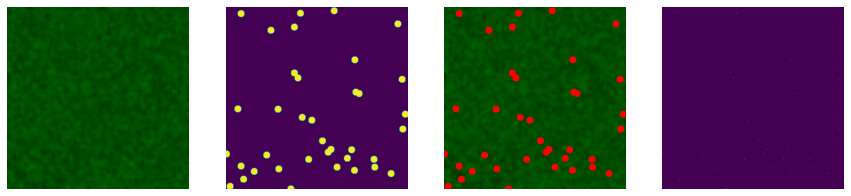

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],
                         radius=10, 
                         shape=berries.shape)
    berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # red

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [2]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img, 
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

## Train a regression model to predict density

In [3]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))  
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.05564174
(12288,) 0.0 0.07250381
(12288,) 0.0 0.071923494


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


1600/1600 [==============================] - 290s 181ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.0552 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0290
Epoch 2/5
1600/1600 [==============================] - 288s 180ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0234 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0171
Epoch 3/5
1600/1600 [==============================] - 296s 185ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0187 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0182
Epoch 4/5
1600/1600 [==============================] - 301s 188ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0191 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0300
Epoch 5/5
1600/1600 [==============================] - 306s 191ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0170 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0150


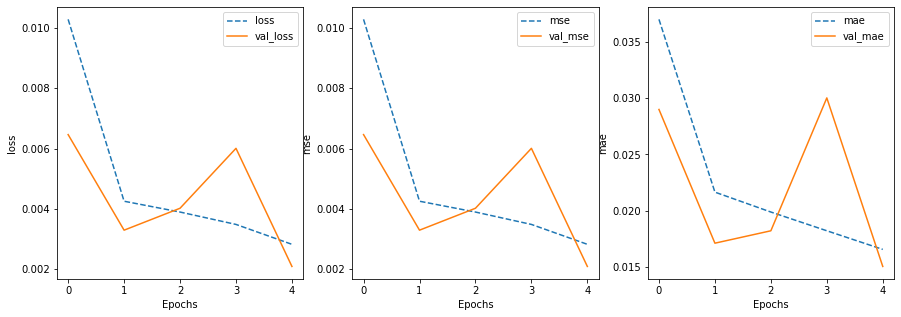

In [4]:
# Train
NUM_TRAIN = 200 # 10000 more realistic
NUM_EVAL = 10 # 1000 more realistic
NUM_EPOCHS = 5

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


66 berries simulated
41 berries simulated
65 berries simulated
65 berries simulated
54 berries simulated
73 berries simulated
25 berries simulated
51 berries simulated
64 berries simulated
65 berries simulated
30 berries simulated
61 berries simulated
70 berries simulated
29 berries simulated
74 berries simulated
58 berries simulated


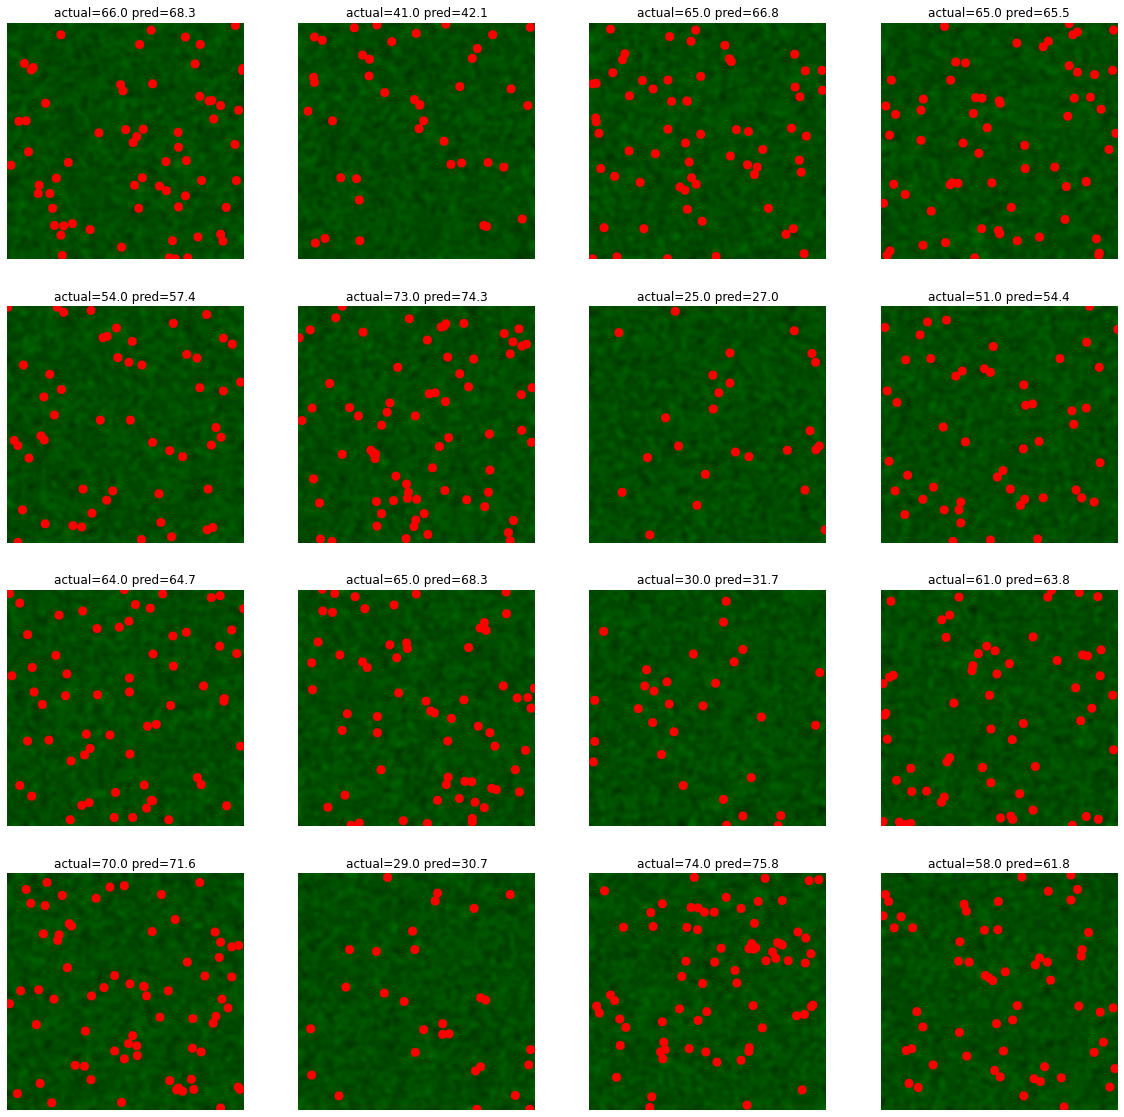

In [5]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

## Plots for book

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


(1, 512, 512, 3) (1, 512, 512, 1)
(256, 12288) (256, 1024) (256,)


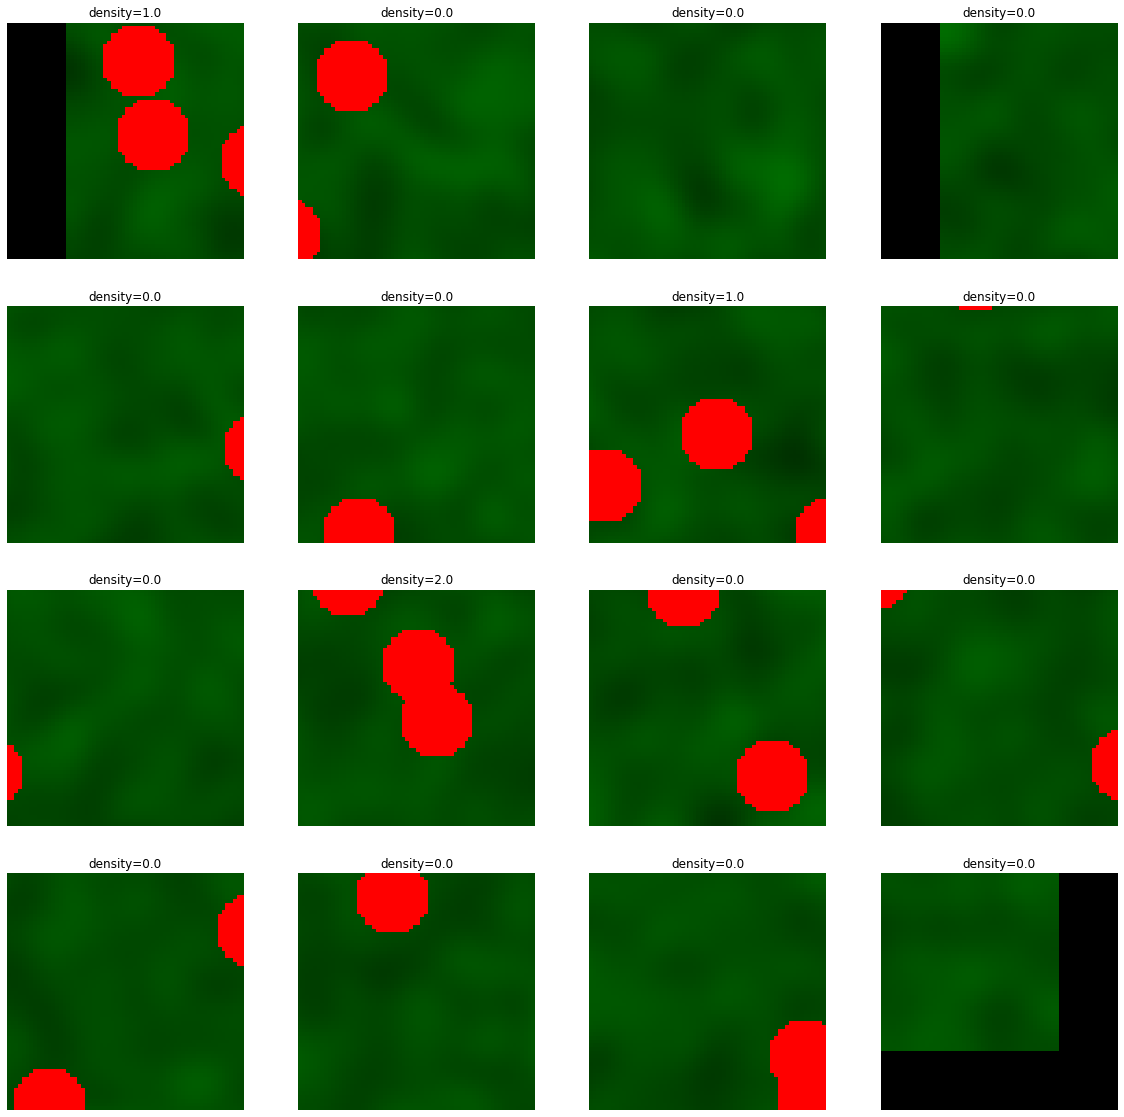

In [30]:
# OPTIONAL, CAN BE OMITTED
img, label = images = generate_image()
patches, labels = get_patches(img, label, verbose=True)

# display a few patches
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  r = np.random.randint(0, patches.shape[0])
  ax[idx//4, idx%4].imshow(tf.reshape(patches[r], [INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS]).numpy())
  ax[idx//4, idx%4].set_title("density={:.1f}".format(labels[r].numpy()))
  ax[idx//4, idx%4].axis('off')

## Actual image

Let's try it on an actual berry image

<img height="512" width="512" src="berries.jpg" />

In [76]:
!file berries.jpg

berries.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 72x72, segment length 16, Exif Standard: [TIFF image data, big-endian, direntries=2, orientation=upper-left], baseline, precision 8, 1531x1148, components 3


In [77]:
contents = tf.io.read_file('./berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

920.8319


The real number is around 300. We are 3x, probably because the real-world berries are larger than the simulated berries.
This indicates that the simulation needs to be improved, perhaps by using berries of different sizes.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.